In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras 
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.misc
from matplotlib.pyplot import imshow
import cv2
import os

Using TensorFlow backend.


In [2]:
datapath = r"C:\Users\Ashwani Singh\anaconda3\envs\tensorflow"

In [3]:
#loads the data and performs preprocessing of image
#Contrast adjustment and class imbalance is handled
def load_data(path):
    images = []
    classes = []
    data = pd.read_csv(path)
    data = data.sample(frac=1).reset_index(drop=True)
    for i,row in data.iterrows():
        img_path = row['Path']
        img_class = row['ClassId']
        
        img = os.path.join(datapath,img_path)
        img = cv2.imread(img)
        img_resize = cv2.resize(img,(32,32),3) #resizes each img to size 32*32*3
        R,G,B = cv2.split(img_resize)          #splits R, G & B values of img
        R = cv2.equalizeHist(R)                #Contrast adjustment of R channel 
        G = cv2.equalizeHist(G)                #Contrast adjustment of G channel
        B = cv2.equalizeHist(B)                #Contrast adjustment of B channel
        new_img = cv2.merge((R,G,B))
        
        if i>0 and i%1000 == 0: 
            print("loaded: ",i," images")
        images.append(new_img)
        classes.append(img_class)
        
    imgs = np.array(images)
    labels = np.array(classes)
    
    return imgs, labels

In [4]:
train_X, train_Y = load_data('gtsrb_Train.csv')
test_X, test_Y = load_data('gtsrb_Test.csv')

loaded:  1000  images
loaded:  2000  images
loaded:  3000  images
loaded:  4000  images
loaded:  5000  images
loaded:  6000  images
loaded:  7000  images
loaded:  8000  images
loaded:  9000  images
loaded:  10000  images
loaded:  11000  images
loaded:  12000  images
loaded:  13000  images
loaded:  14000  images
loaded:  15000  images
loaded:  16000  images
loaded:  17000  images
loaded:  18000  images
loaded:  19000  images
loaded:  20000  images
loaded:  21000  images
loaded:  22000  images
loaded:  23000  images
loaded:  24000  images
loaded:  25000  images
loaded:  26000  images
loaded:  27000  images
loaded:  28000  images
loaded:  29000  images
loaded:  30000  images
loaded:  31000  images
loaded:  32000  images
loaded:  33000  images
loaded:  34000  images
loaded:  35000  images
loaded:  36000  images
loaded:  37000  images
loaded:  38000  images
loaded:  39000  images
loaded:  1000  images
loaded:  2000  images
loaded:  3000  images
loaded:  4000  images
loaded:  5000  images
lo

In [5]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(39209, 32, 32, 3)
(39209,)
(12630, 32, 32, 3)
(12630,)


In [6]:
def plot_signs(X, Y):
    for i in range(20):
        plt.subplot(5, 4, i+1)
        plt.tight_layout()
        plt.imshow(X[i], cmap='hsv')
        plt.title('Class:{}'.format(Y[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

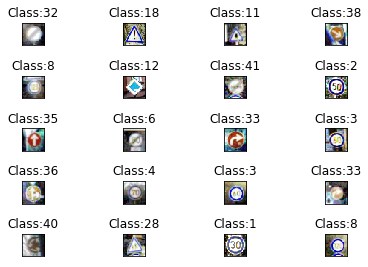

In [7]:
plot_signs(train_X,train_Y)

In [8]:
#Normalizing the data
train_X = train_X.astype('float32')/255.0
test_X = test_X.astype('float32')/255.0

train_Y = to_categorical(train_Y)
test_Y = to_categorical(test_Y)

class_totals = train_Y.sum(axis=0)
class_weights = class_totals.max() / class_totals

In [9]:
import tensorflow
def model(width,height,depth,classes):
    model = Sequential()
    
    model.add(Conv2D(32,(5,5),activation='relu', input_shape=(width,height,depth)))              
    model.add(BatchNormalization())         
    model.add(MaxPooling2D((2,2), strides=(2,2)))
              
    model.add(Conv2D(48,(5,5),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
              
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.2))
              
    model.add(Dense(84, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(classes, activation='softmax'))
    return model

In [10]:
model = model(32,32,3,43)

In [11]:
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 48)        38448     
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 48)        192       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 48)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1200)             

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Data Augmentation
datagen = ImageDataGenerator(
            rotation_range=10, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            zoom_range=0.1)
datagen.fit(train_X)

In [14]:
# Set a learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

In [15]:
model.fit_generator(datagen.flow(train_X, train_Y, batch_size=128), steps_per_epoch=len(train_X)/128, epochs=20, validation_data=(test_X, test_Y), 
                    class_weight=class_weights,
                    callbacks=[reduce_lr])

Epoch 1/20
307/306 [==============================] - 93s 304ms/step - loss: 1.6022 - accuracy: 0.5313 - val_loss: 2.0831 - val_accuracy: 0.4074
Epoch 2/20
307/306 [==============================] - 93s 304ms/step - loss: 0.5212 - accuracy: 0.8317 - val_loss: 0.2728 - val_accuracy: 0.9195
Epoch 3/20
307/306 [==============================] - 93s 304ms/step - loss: 0.2830 - accuracy: 0.9088 - val_loss: 0.3002 - val_accuracy: 0.9106
Epoch 4/20
307/306 [==============================] - 94s 305ms/step - loss: 0.2015 - accuracy: 0.9359 - val_loss: 0.2569 - val_accuracy: 0.9215
Epoch 5/20
307/306 [==============================] - 93s 304ms/step - loss: 0.1688 - accuracy: 0.9449 - val_loss: 0.1887 - val_accuracy: 0.9439
Epoch 6/20
307/306 [==============================] - 93s 304ms/step - loss: 0.1387 - accuracy: 0.9546 - val_loss: 0.2357 - val_accuracy: 0.9319
Epoch 7/20
307/306 [==============================] - 93s 302ms/step - loss: 0.1209 - accuracy: 0.9611 - val_loss: 0.2415 - val_ac